# Génération de Données : Maintenance Prédictive

Ce notebook génère deux ensembles de données synthétiques pour simuler un scénario de maintenance prédictive industrielle. 
L'objectif est de prédire si une machine va tomber en panne (`failure`) en fonction de données de capteurs.

Nous simulerons ensuite un **drift** (dérive) sur un des capteurs dans les données de production.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

np.random.seed(42)
n_samples = 2000

# Phase A : données historiques (Fonctionnement normal)
temperature_A = np.random.normal(loc=75, scale=5, size=n_samples)    # Température moteur (°C)
vibration_A = np.random.gamma(shape=2, scale=1.5, size=n_samples)    # Vibration (mm/s)
pressure_A = np.random.normal(loc=120, scale=10, size=n_samples)     # Pression hydraulique (Bar)
rpm_A = np.random.uniform(1500, 3000, size=n_samples)                # Vitesse de rotation (RPM)

## Phase A : Génération des données historiques

Nous générons 2000 échantillons représentant des relevés de capteurs sur des machines :
- **temperature** : Température du moteur (moyenne=75°C, écart-type=5)
- **vibration** : Niveau de vibration (loi Gamma, asymétrique)
- **pressure** : Pression hydraulique (moyenne=120 Bar, écart-type=10)
- **rpm** : Vitesse de rotation (uniforme entre 1500 et 3000 tours/min)

In [16]:
# Simulation de la variable cible : FAILURE (Panne)
# Modèle sous-jacent : La température et les vibrations augmentent le risque de panne.

logits_A = (
    0.15 * (temperature_A - 75)       # Impact fort de la température
    + 0.8 * (vibration_A - 3)         # Impact fort des vibrations
    + 0.02 * (pressure_A - 120)       # Impact modéré de la pression
    - 0.0005 * (rpm_A - 2250)         # Impact faible vitesse
    - 3.5                             # Biais pour rendre les pannes rares (classe déséquilibrée)
)

proba_failure_A = 1 / (1 + np.exp(-logits_A))
failure_A = np.random.binomial(1, proba_failure_A)

print(f"Taux de panne Phase A : {np.mean(failure_A):.2%}")

Taux de panne Phase A : 10.25%


### Calcul de la probabilité de panne (Phase A)

Nous définissons la probabilité de panne (`failure`) à l'aide d'une fonction logistique.
Les coefficients ont été choisis pour que :
- Une **température élevée** augmente le risque.
- De **fortes vibrations** augmentent le risque.
- Le taux global de panne reste réaliste (faible).

In [17]:
data_A = pd.DataFrame({
    "temperature": temperature_A,
    "vibration": vibration_A,
    "pressure": pressure_A,
    "rpm": rpm_A,
    "failure": failure_A
})

data_A.head()

,temperature,vibration,pressure,rpm,failure
0,77.483571,1.407211,128.648244,1800.924557,0
1,74.308678,2.230454,129.533975,1930.995500,0
2,78.238443,0.333721,128.262315,1742.843415,0
3,82.615149,2.936206,117.035846,1873.943025,0
4,73.829233,4.006256,105.380062,1837.330170,0


### Création du DataFrame Phase A

Construction du jeu de données d'entraînement avec toutes les variables.

In [18]:
# Phase B : Données de production avec DRIFT
# Simulation : Un capteur de température décalibré ou une surchauffe globale des machines

temperature_B = np.random.normal(loc=82, scale=7, size=n_samples)    # DRIFT : Moyenne 75 -> 82, Variance augmente
vibration_B = np.random.gamma(shape=2, scale=1.5, size=n_samples)    # Pas de drift (loi identique)
pressure_B = np.random.normal(loc=120, scale=10, size=n_samples)     # Pas de drift
rpm_B = np.random.uniform(1500, 3000, size=n_samples)                # Pas de drift

## Phase B : Génération des données avec Drift

Simulation d'un changement dans la distribution des données (Data Drift) :
- **temperature** : La moyenne passe de 75°C à 82°C (Surchauffe / Dérive capteur).
- **autres variables** : Les distributions restent identiques à la Phase A.

Ce drift devrait impacter les prédictions du modèle car la température est une variable importante.

In [19]:
# On garde la MÊME relation physique (le modèle de la réalité ne change pas, c'est les données qui changent)
logits_B = (
    0.15 * (temperature_B - 75)
    + 0.8 * (vibration_B - 3)
    + 0.02 * (pressure_B - 120)
    - 0.0005 * (rpm_B - 2250)
    - 3.5
)

proba_failure_B = 1 / (1 + np.exp(-logits_B))
failure_B = np.random.binomial(1, proba_failure_B)

print(f"Taux de panne Phase B : {np.mean(failure_B):.2%}")

Taux de panne Phase B : 17.50%


### Calcul du Target Phase B

La physique des pannes reste la même (mêmes formule logistique), mais comme la température moyenne a augmenté, nous nous attendons à observer mécaniquement **plus de pannes** en Phase B.

In [20]:
data_B = pd.DataFrame({
    "temperature": temperature_B,
    "vibration": vibration_B,
    "pressure": pressure_B,
    "rpm": rpm_B,
    "failure": failure_B
})

data_B.head()

,temperature,vibration,pressure,rpm,failure
0,87.843800,3.339557,123.104793,1878.256658,1
1,78.299730,2.691316,109.617693,2179.848248,0
2,95.315982,3.717270,127.758975,2458.526143,1
3,96.424823,6.423241,125.472504,2816.197425,1
4,91.541338,1.345299,117.695471,2286.931652,0


### Création du DataFrame Phase B

Construction du jeu de données de production avec drift.

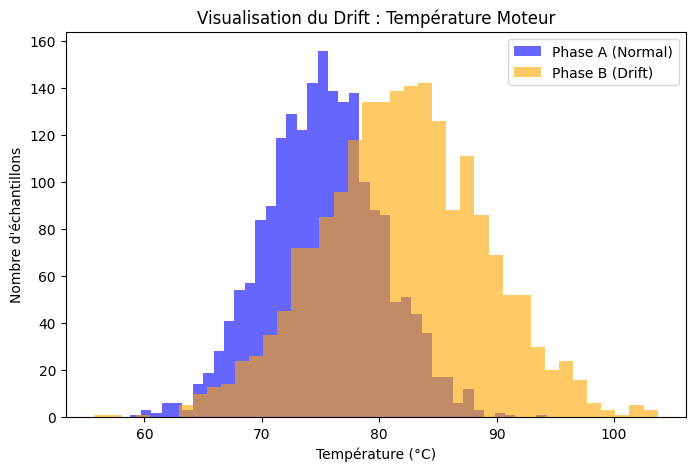

✓ Figure sauvegardée dans figures/temperature_drift.png


In [21]:
plt.figure(figsize=(8, 5))
plt.hist(temperature_A, bins=40, alpha=0.6, label="Phase A (Normal)", color='blue')
plt.hist(temperature_B, bins=40, alpha=0.6, label="Phase B (Drift)", color='orange')
plt.legend()
plt.xlabel("Température (°C)")
plt.ylabel("Nombre d'échantillons")
plt.title("Visualisation du Drift : Température Moteur")
plt.savefig("images/temperature_drift.png", dpi=300, bbox_inches='tight')
plt.show()

print("✓ Figure sauvegardée dans figures/temperature_drift.png")

## Visualisation du drift

Comparaison des distributions de la variable `temperature` entre les deux phases. On observe clairement le décalage vers la droite (valeurs plus élevées) en Phase B.

In [22]:
# Sauvegarder les datasets (mêmes noms de fichiers pour compatibilité, contenu différent)
data_A.to_csv("data/phase_A_historical.csv", index=False)
data_B.to_csv("data/phase_B_production.csv", index=False)

print("✓ Nouveaux datasets 'Maintenance' sauvegardés dans le dossier 'data/'")
print(f"  - Phase A: {len(data_A)} lignes (Colonnes: {list(data_A.columns)})")
print(f"  - Phase B: {len(data_B)} lignes")

✓ Nouveaux datasets 'Maintenance' sauvegardés dans le dossier 'data/'
  - Phase A: 2000 lignes (Colonnes: ['temperature', 'vibration', 'pressure', 'rpm', 'failure'])
  - Phase B: 2000 lignes


## Sauvegarde des datasets

Exportation des données vers le dossier `data/` au format CSV.